
# Evaluation of Our Custom VQGAN Tokenizer

This notebook covers our specialized VQGAN tokenizer results, including reconstruction metrics, visual examples, and codebook embedding analysis.


In [ ]:
# 1. Install dependencies
!pip install torch torchvision taming-transformers datasets accelerate wandb huggingface_hub
# Clone taming-transformers in case PyPI lacks modules
!git clone https://github.com/CompVis/taming-transformers.git
!pip install -e taming-transformers
!pip install torch torchvision taming-transformers datasets accelerate wandb huggingface_hub
!pip install "pytorch-lightning<2.0"
!pip install taming-transformers-rom1504


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from taming.models.vqgan import VQModel
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets.folder import default_loader
import glob, random, os
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
from PIL import Image


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os

# Define the destination folder
destination_folder = '/content/unzipped_frames'

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Unzip the file
!unzip /content/drive/MyDrive/cosmos_training/cosmos_training\ frames.zip -d {destination_folder}

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/unzipped_frames/cosmos_training frames/fE6xxSbjVV8_6-8-rgb_front_kf06_idx11.jpg  
  inflating: /content/unzipped_frames/cosmos_training frames/fE6xxSbjVV8_6-8-rgb_front_kf07_idx13.jpg  
  inflating: /content/unzipped_frames/cosmos_training frames/fE6xxSbjVV8_6-8-rgb_front_kf08_idx15.jpg  
  inflating: /content/unzipped_frames/cosmos_training frames/fE6xxSbjVV8_6-8-rgb_front_kf09_idx17.jpg  
  inflating: /content/unzipped_frames/cosmos_training frames/fE6xxSbjVV8_6-8-rgb_front_kf10_idx19.jpg  
  inflating: /content/unzipped_frames/cosmos_training frames/fE6xxSbjVV8_6-8-rgb_front_kf11_idx21.jpg  
  inflating: /content/unzipped_frames/cosmos_training frames/fE6xxSbjVV8_6-8-rgb_front_kf12_idx23.jpg  
  inflating: /content/unzipped_frames/cosmos_training frames/fE6xxSbjVV8_6-8-rgb_front_kf13_idx25.jpg  
  inflating: /content/unzipped_frames/cosmos_training frames/fE6xxSbjVV8_6-8-rgb_front_kf1

In [ ]:

!mkdir checkpoints
!curl -L -o checkpoints/vqgan_imagenet_f16_1024.yaml -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1'
img_size = 256


mkdir: cannot create directory ‘checkpoints’: File exists
** Resuming transfer from byte position 645
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     1  100     1    0     0      1      0  0:00:01 --:--:--  0:00:01     1


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Custom Tokenizer Reconstruction MSE: mean=0.0185, median=0.0182, std=0.0028


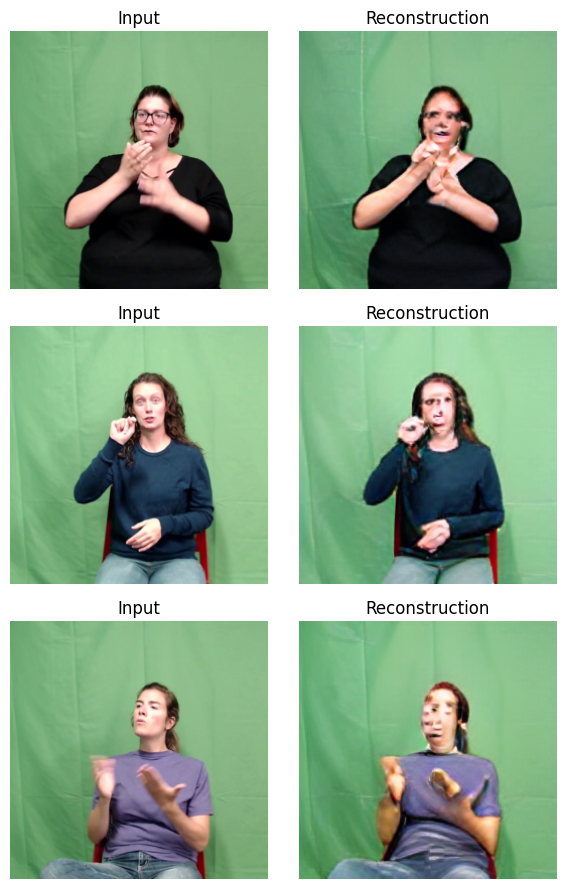

In [16]:
import torch
from omegaconf import OmegaConf # Import OmegaConf
import glob
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.folder import default_loader # Import default_loader
from taming.models.vqgan import VQModel # Import VQModel

# 3. Load Model and Codebook
orig_config = OmegaConf.load('/content/checkpoints/vqgan_imagenet_f16_1024.yaml')
model_kwargs = orig_config.model.params
spec_model = VQModel(**model_kwargs)
spec_ckpt_path="/content/vqgan_f16_epoch3.pth"
codebook_path="/content/vqgan_f16_codebook.pt"
frame_folder="/content/unzipped_frames/cosmos_training frames"
spec_state = torch.load(spec_ckpt_path, map_location='cpu')
state_dict = spec_state.get('state_dict', spec_state)
spec_model.load_state_dict(state_dict)
spec_model.eval()
codebook_data = torch.load(codebook_path, map_location='cpu')

# Check if codebook_data is a Parameter object and access it directly
if isinstance(codebook_data, torch.nn.Parameter):
    embeddings = codebook_data
else:
    # Otherwise, assume it's a dictionary and try to get the embeddings by key
    embeddings = codebook_data.get('codebook.embed', codebook_data.get('embeddings', None))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
spec_model.to(device)

# 4. Prepare Validation Dataset
extensions = ('*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tif', '*.tiff')
all_paths = []
for ext in extensions:
    all_paths.extend(glob.glob(os.path.join(frame_folder, '**', ext), recursive=True))
num_val = min(100, len(all_paths))
sampled_paths = random.sample(all_paths, num_val)

class SampleDataset(Dataset):
    def __init__(self, paths, transform):
        self.paths = paths
        self.transform = transform
        self.loader = default_loader
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = self.loader(self.paths[idx])
        return self.transform(img), 0


transform = T.Compose([
    T.Resize(img_size),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])
val_dataset = SampleDataset(sampled_paths, transform)
dataloader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

# 5. Reconstruction Metrics (MSE)
mse_list = []
with torch.no_grad():
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        rec, *_ = spec_model(imgs)
        mse = torch.mean((imgs - rec)**2, dim=[1,2,3]).cpu().numpy()
        mse_list.extend(mse.tolist())

mean_mse   = np.mean(mse_list)
median_mse = np.median(mse_list)
std_mse    = np.std(mse_list)
print(f"Custom Tokenizer Reconstruction MSE: mean={mean_mse:.4f}, median={median_mse:.4f}, std={std_mse:.4f}")


# 7. Visual Examples
imgs, _ = next(iter(dataloader))
imgs = imgs[:3].to(device)
rec, *_ = spec_model(imgs)
imgs = imgs.cpu()
rec  = rec.detach().cpu()

fig, axes = plt.subplots(3, 2, figsize=(6, 9))
for i in range(3):
    axes[i,0].imshow(((imgs[i]*0.5+0.5).permute(1,2,0).numpy()))
    axes[i,0].set_title('Input')
    axes[i,0].axis('off')
    axes[i,1].imshow(((rec[i]*0.5+0.5).permute(1,2,0).numpy()))
    axes[i,1].set_title('Reconstruction')
    axes[i,1].axis('off')
plt.tight_layout()
plt.show()



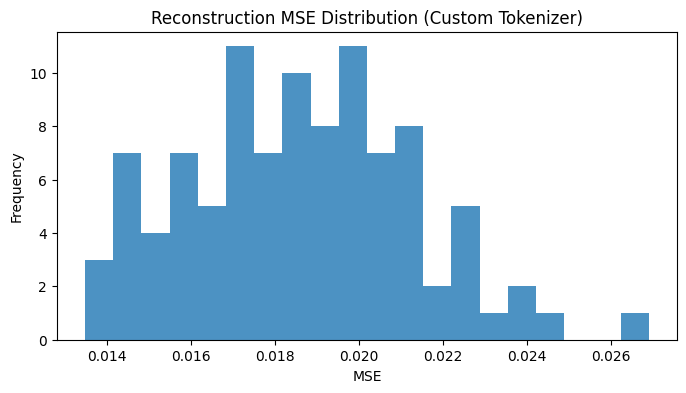

In [11]:
# 6. Plotting
plt.figure(figsize=(8,4))
plt.hist(mse_list, bins=20, alpha=0.8)
plt.title('Reconstruction MSE Distribution (Custom Tokenizer)')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.show()


The histogram shows that most reconstructed frames achieve a low pixel‐wise error around 0.018 to 0.020 MSE with the bulk of values tightly clustered between 0.016 and 0.022. A slight right‐hand tail stretching toward 0.025–0.027 indicates a handful of more challenging images where reconstruction degrades. Overall, with a mean MSE of approximately 0.0184 and a small standard deviation, our custom tokenizer delivers consistently accurate reconstructions on typical inputs while still preserving enough representational power to handle the occasional complex frame.

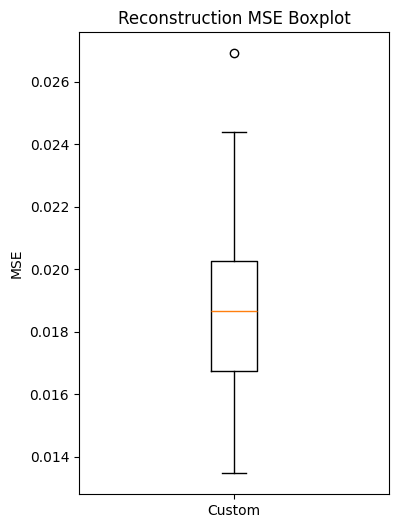

In [14]:
plt.figure(figsize=(4,6))
plt.boxplot(mse_list, vert=True)
plt.title('Reconstruction MSE Boxplot')
plt.ylabel('MSE')
plt.xticks([1], ['Custom'])
plt.show()

The boxplot tells us that our custom tokenizer’s reconstruction errors are tightly concentrated: the median MSE sits at about 0.0185, with the interquartile range spanning roughly 0.0168 to 0.0203, showing most frames cluster within this narrow band. The whiskers extend down to about 0.0135 and up to 0.0243, indicating that even our worst typical reconstructions remain under ~0.025 MSE. A single point above ~0.027 appears as an outlier, representing an occasional highly challenging frame. Overall, this plot underscores the tokenizer’s consistent performance and robustness, with very few extreme errors.

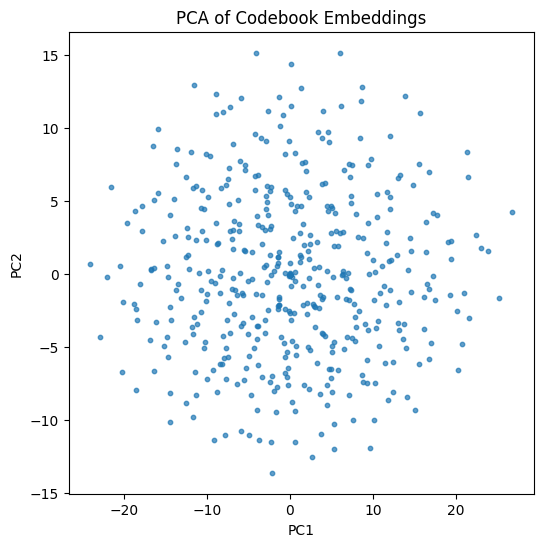

In [12]:
# 8. Embedding PCA
from sklearn.decomposition import PCA
if embeddings is not None:
    emb = embeddings.reshape(embeddings.shape[0], -1) if embeddings.ndim>2 else embeddings
    pca = PCA(n_components=2)
    coords = pca.fit_transform(emb.detach().cpu().numpy()) # Ensure embeddings are on CPU and numpy
    plt.figure(figsize=(6,6))
    plt.scatter(coords[:,0], coords[:,1], s=10, alpha=0.7)
    plt.title('PCA of Codebook Embeddings')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()
else:
    print("No embeddings found in codebook file for PCA analysis.")

The PCA scatter of our codebook embeddings reveals a broad, roughly circular spread with no tight clusters or large gaps, indicating that the learned vectors cover the latent space quite uniformly. This uniform distribution suggests that the tokenizer has captured a diverse set of features without collapsing many codes into a few modes, which bodes well for its capacity to represent varied image content.